In [48]:
!git clone https://github.com/Patipol-BKK/alphatrash-dataset

Cloning into 'alphatrash-dataset'...
remote: Enumerating objects: 5458, done.
remote: Counting objects: 100% (1600/1600), done.
remote: Compressing objects: 100% (1594/1594), done.
^Cceiving objects:   7% (383/5458), 148.48 MiB | 37.11 MiB/s


In [49]:
%cd alphatrash-dataset/trash_dataset

[Errno 2] No such file or directory: 'alphatrash-dataset/trash_dataset'
/kaggle/working/alphatrash-dataset/trash_dataset/alphatrash-dataset/trash_dataset/alphatrash-dataset/trash_dataset


In [50]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, purpose, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.purpose = purpose
        self.image_list = []
        self.labels = []

        for label_type in ['general', 'metal', 'organic', 'paper', 'plastic']:
            image_files = [file for file in os.listdir(os.path.join(root_dir, purpose, label_type)) if file.endswith('.jpeg')]
            self.image_list.extend(image_files)
            self.labels.extend([label_type] * len(image_files))

        self.label_to_num = { 'general' : 0, 'organic' : 1, 'metal' : 2, 'paper' : 2, 'plastic' : 2}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.purpose, self.labels[idx], self.image_list[idx])
        image = cv2.imread(img_name)
        #image = cv2.resize(image, (224, 224))
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if self.transform:
            image = self.transform(image)

        return image, self.label_to_num[self.labels[idx]]

# Set the path to the dataset directory
dataset_path = '/kaggle/working/alphatrash-dataset/trash_dataset'

transformer = {
    'original': transform.Compose([
        transform.Resize((224, 224)),
        transform.ToTensor(),
        transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
]),
   'dataset1': transform.Compose([
       transform.Resize((224, 224)),
       transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
       transform.RandomRotation(5),
       transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
       transform.ToTensor(),
       transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
])
}

# Create the custom dataset
custom_dataset_train0 = CustomDataset(root_dir=dataset_path, purpose = 'train', transform=transformer['original'])
custom_dataset_train1 = CustomDataset(root_dir=dataset_path, purpose = 'train', transform=transformer['dataset1'])
train_set = ConcatDataset([custom_dataset_train0, custom_dataset_train1])
custom_dataset_test0 = CustomDataset(root_dir=dataset_path, purpose = 'test', transform=transformer['original'])
custom_dataset_test1 = CustomDataset(root_dir=dataset_path, purpose = 'test', transform=transformer['dataset1'])
test_set = ConcatDataset([custom_dataset_test0, custom_dataset_test1])
custom_dataset_val0 = CustomDataset(root_dir=dataset_path, purpose = 'val', transform=transformer['original'])
custom_dataset_val1 = CustomDataset(root_dir=dataset_path, purpose = 'val', transform=transformer['dataset1'])
val_set = ConcatDataset([custom_dataset_val0, custom_dataset_val1])

# Print the shapes of the images and labels arrays
print('Train size:', len(custom_dataset_train0))
print('Training set size:', len(train_set))
print('Test size:', len(custom_dataset_test0))
print('Test set size:', len(test_set))
print('Val size:', len(custom_dataset_val0))
print('Val set size:', len(val_set))

Train size: 3986
Training set size: 7972
Test size: 849
Test set size: 1698
Val size: 856
Val set size: 1712


In [51]:
import torch
import torchvision

batch_size = 32

trainloader = DataLoader(train_set, batch_size=batch_size,
                         shuffle=True, num_workers=4)
testloader = DataLoader(test_set, batch_size=batch_size,
                         shuffle=False, num_workers=4)
valloader = DataLoader(val_set, batch_size=batch_size,
                         shuffle=False, num_workers=4)

# The rest of your code remains the same

classes = ( 'other', 'organic', 'recyclable')

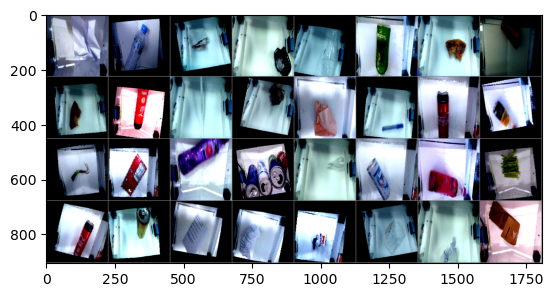

recyclable recyclable recyclable other


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [53]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class RNet(nn.Module):
    def __init__(self, freeze_layers=True):
        super().__init__()
        self.conv_net = torchvision.models.resnet50(weights=True)
        if freeze_layers:
            for param in self.conv_net.parameters():
                param.requires_grad = False
        #num_ftrs = self.conv_net.fc.in_features
        self.fc = nn.Linear(1000, 128)
        self.head = nn.Linear(128, 3)

    def forward(self, x, print_mode=False):
        if print_mode:
          print("Input:", x.shape)
        x = self.conv_net(x)
        if print_mode:
          print("Conv:", x.shape)
        x = F.relu(self.fc(x))
        if print_mode:
          print("FC1", x.shape)
        x = self.head(x)
        if print_mode:
          print("FC3",x.shape)
        return x

net = RNet(freeze_layers=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s] 


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device (CPU or GPU)
net.to(device)

# Move the data tensors to the selected device

images = images.to(device)
labels = labels.to(device)

In [55]:
print(images.shape)
print(net(images).shape)
out = net(images, True)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3])
Input: torch.Size([32, 3, 224, 224])
Conv: torch.Size([32, 1000])
FC1 torch.Size([32, 128])
FC3 torch.Size([32, 3])


In [56]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
print(device)

cuda


In [57]:
import copy

def train_eval(phase, loader):
    if phase == 'train':
        net.train()
    else:
        net.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        if phase == 'train':
            loss.backward()
            optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_accuracy += (predicted == labels.data).float().mean().item()
        #torch.cuda.empty_cache()

    running_loss /= len(loader)
    running_accuracy /= len(loader)

    if phase == 'train':
        scheduler.step(running_loss)

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{50}, '
          f'Loss: {running_loss:.3f}, '
          f'Running Accuracy: {running_accuracy:.3f}')
    return running_accuracy

best_accuracy = 0.0
for epoch in range(25):
    train_accuracy = train_eval('train', trainloader)
    val_accuracy = train_eval('eval', valloader)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = copy.deepcopy(net.state_dict())  # Save the current model's state dictionary

net.load_state_dict(best_model)
optimizer = optim.AdamW(net.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)

for epoch in range(25):
    train_accuracy = train_eval('train', trainloader)
    val_accuracy = train_eval('eval', valloader)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = copy.deepcopy(net.state_dict())  # Save the current model's state dictionary

net.load_state_dict(best_model)

print('Finished Training')

torch.save(net.state_dict(), 'best_model.pth')

Epoch 1/50, Loss: 0.396, Running Accuracy: 0.837
Epoch 1/50, Loss: 0.279, Running Accuracy: 0.884
Epoch 2/50, Loss: 0.275, Running Accuracy: 0.885
Epoch 2/50, Loss: 0.235, Running Accuracy: 0.909
Epoch 3/50, Loss: 0.238, Running Accuracy: 0.905
Epoch 3/50, Loss: 0.235, Running Accuracy: 0.898
Epoch 4/50, Loss: 0.210, Running Accuracy: 0.915
Epoch 4/50, Loss: 0.191, Running Accuracy: 0.926
Epoch 5/50, Loss: 0.198, Running Accuracy: 0.921
Epoch 5/50, Loss: 0.203, Running Accuracy: 0.919
Epoch 6/50, Loss: 0.194, Running Accuracy: 0.924
Epoch 6/50, Loss: 0.160, Running Accuracy: 0.933
Epoch 7/50, Loss: 0.180, Running Accuracy: 0.925
Epoch 7/50, Loss: 0.161, Running Accuracy: 0.937
Epoch 8/50, Loss: 0.160, Running Accuracy: 0.939
Epoch 8/50, Loss: 0.173, Running Accuracy: 0.930
Epoch 9/50, Loss: 0.151, Running Accuracy: 0.942
Epoch 9/50, Loss: 0.163, Running Accuracy: 0.935
Epoch 10/50, Loss: 0.149, Running Accuracy: 0.939
Epoch 10/50, Loss: 0.187, Running Accuracy: 0.932
Epoch 11/50, Loss:

KeyboardInterrupt: 

In [59]:
net.load_state_dict(best_model)

<All keys matched successfully>

In [61]:
torch.save(net.state_dict(), 'best_model.pth')

In [65]:
net.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [70]:
correct_train = 0
total_train = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
correct_val = 0
total_val = 0
with torch.no_grad():
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 8000 train images: {100 * (correct_train / total_train):.3f} %')
print(f'Accuracy of the network on the 1700 test images: {100 * (correct_test / total_test):.3f} %')
print(f'Accuracy of the network on the 1700 validation images: {100 * (correct_val / total_val):.3f} %')

Accuracy of the network on the 8000 train images: 97.780 %
Accuracy of the network on the 1700 test images: 95.819 %
Accuracy of the network on the 1700 validation images: 94.451 %
